In [54]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools
from scipy.special import kn
from scipy import optimize
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read data

In [2]:
config = '24I/ml_0p01'
# config = '24I/ml_0p005'
# config = '32I/ml0p008'
# config = '32I/ml0p006'
# config = '32I/ml0p004'
f3pt_path = '/Users/theoares/Dropbox (MIT)/research/0nubb/short_distance/analysis_output/' + config + '/SD_output.h5'
n_ops = 5
f = h5py.File(f3pt_path, 'r')
L, T = f['L'][()], f['T'][()]
C2pt_tavg = f['pion-00WW'][()]
C3pt_tavg = f['C3pt'][()]    # TODO now these should all be bootstrapped
Cnpt = f['Cnpt'][()]
# R = f['R'][()]
R_boot = f['R'][()]
f.close()

In [4]:
# R_boot = bootstrap(R)
R_μ = np.mean(R_boot, axis = 0)
R_σ = np.std(R_boot, axis = 0, ddof = 1)

In [5]:
# Try to replicate the plots in 24I/ml_0p01/plots, this is what is generated by plot_pion_0vbb_4quark_ratios.py
data_slice = np.zeros((n_boot, n_ops, T), dtype = np.float64)
# data_slice = np.zeros((n_files, n_ops, T), dtype = np.float64)
plot_domain = range(T)
for i in range(n_ops):
    for sep in range(T):
        if sep % 2 == 0:
            data_slice[:, i, sep] = np.real(R_boot[:, i, sep // 2, sep])
        else:
            data_slice[:, i, sep] = np.real((R_boot[:, i, sep // 2, sep] + R_boot[:, i, sep // 2 + 1, sep]) / 2)
data_plot_μ = np.mean(data_slice, axis = 0)
data_plot_σ = np.std(data_slice, axis = 0, ddof = 1)

## Fit plateau to data_slice

In [46]:
Rbt = np.einsum('bit->ibt', data_slice[:, :, :(T // 2)])
nb = Rbt.shape[1]

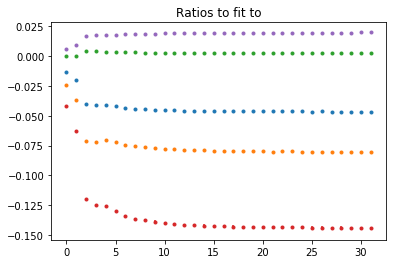

In [22]:
subplt_domain = range(T // 2)
plt.figure()
for i in range(n_ops):
    plt.errorbar(subplt_domain, np.mean(Rbt[i], axis = 0), np.std(Rbt[i], axis = 0, ddof = 1), fmt = '.')
# plt.ylim((0.017, 0.02))
plt.title('Ratios to fit to')
plt.show()

Compute the covariance of the data $\{R_b(t)\}$, making sure that everything checks out and makes sense. Note that the variance with 1 dof is:
$$
\sigma^2(t) = \frac{1}{n_b - 1} \sum_b \left( R_b(t) - \overline{R}(t) \right)^2
$$
Note that this is equivalent to the definition in terms of expectation values:
$$
Var(t) = \sigma_R^2(t) = \mathbb{E}[R_b(t) - \mathbb{E}[R_b(t)]]
$$

The covariance of the data is likewise defined in terms of expectation values:
$$
\mathrm{Cov}(t_1, t_2) = \mathbb{E}[(R_b(t_1) - \mathbb{E}[R_b(t_1)])\cdot (R_b(t_2) - \mathbb{E}[R_b(t_2)])]
$$
We can explicitly write this out (with 1 degree of freedom to make it unbiased) as:
$$
    \mathrm{Cov}(t_1, t_2) = \frac{1}{n_b - 1}\sum_b(R_b(t_1) - \overline{R}(t_1)) (R_b(t_2) - \overline{R}(t_2))
$$

In [27]:
Rop0 = Rbt[0]
Rop0_mu = np.mean(Rop0, axis = 0)

In [48]:
np.std(Rop0, axis = 0, ddof = 1) ** 2

array([2.34834040e-09, 9.54412098e-09, 3.55882415e-08, 4.50549311e-08,
       4.97645295e-08, 4.16844437e-08, 5.53921131e-08, 5.86469345e-08,
       5.61495185e-08, 7.39009422e-08, 8.43305963e-08, 9.26814996e-08,
       1.18951148e-07, 1.17085459e-07, 1.14744707e-07, 1.20453903e-07,
       1.37179623e-07, 1.22441095e-07, 1.36958369e-07, 1.27890054e-07,
       1.36144492e-07, 1.53327696e-07, 1.28044063e-07, 1.39208895e-07,
       1.28123129e-07, 1.39416712e-07, 1.51023261e-07, 1.44016029e-07,
       1.53814134e-07, 1.38567853e-07, 1.51529052e-07, 1.27932037e-07])

In [49]:
var = np.sum((Rop0 - Rop0_mu) ** 2, axis = 0) / (nb - 1)
print(var)

[2.34834040e-09 9.54412098e-09 3.55882415e-08 4.50549311e-08
 4.97645295e-08 4.16844437e-08 5.53921131e-08 5.86469345e-08
 5.61495185e-08 7.39009422e-08 8.43305963e-08 9.26814996e-08
 1.18951148e-07 1.17085459e-07 1.14744707e-07 1.20453903e-07
 1.37179623e-07 1.22441095e-07 1.36958369e-07 1.27890054e-07
 1.36144492e-07 1.53327696e-07 1.28044063e-07 1.39208895e-07
 1.28123129e-07 1.39416712e-07 1.51023261e-07 1.44016029e-07
 1.53814134e-07 1.38567853e-07 1.51529052e-07 1.27932037e-07]


In [52]:
covar = np.einsum('bi,bj->ij', Rop0 - Rop0_mu, Rop0 - Rop0_mu) / (nb - 1)
print(covar)

[[2.34834040e-09 3.68079617e-09 6.13753987e-09 ... 1.49611854e-08
  1.49891222e-08 1.32029779e-08]
 [3.68079617e-09 9.54412098e-09 1.42796159e-08 ... 2.48330314e-08
  2.17795804e-08 2.12008755e-08]
 [6.13753987e-09 1.42796159e-08 3.55882415e-08 ... 5.59645084e-08
  5.00295177e-08 4.46622025e-08]
 ...
 [1.49611854e-08 2.48330314e-08 5.59645084e-08 ... 1.38567853e-07
  1.37816188e-07 1.25798397e-07]
 [1.49891222e-08 2.17795804e-08 5.00295177e-08 ... 1.37816188e-07
  1.51529052e-07 1.32916540e-07]
 [1.32029779e-08 2.12008755e-08 4.46622025e-08 ... 1.25798397e-07
  1.32916540e-07 1.27932037e-07]]


In [45]:
np.cov(Rop0.T, ddof = 1)

array([[2.34834040e-09, 3.68079617e-09, 6.13753987e-09, ...,
        1.49611854e-08, 1.49891222e-08, 1.32029779e-08],
       [3.68079617e-09, 9.54412098e-09, 1.42796159e-08, ...,
        2.48330314e-08, 2.17795804e-08, 2.12008755e-08],
       [6.13753987e-09, 1.42796159e-08, 3.55882415e-08, ...,
        5.59645084e-08, 5.00295177e-08, 4.46622025e-08],
       ...,
       [1.49611854e-08, 2.48330314e-08, 5.59645084e-08, ...,
        1.38567853e-07, 1.37816188e-07, 1.25798397e-07],
       [1.49891222e-08, 2.17795804e-08, 5.00295177e-08, ...,
        1.37816188e-07, 1.51529052e-07, 1.32916540e-07],
       [1.32029779e-08, 2.12008755e-08, 4.46622025e-08, ...,
        1.25798397e-07, 1.32916540e-07, 1.27932037e-07]])

In [58]:
get_covariance(Rop0)

array([[2.34834040e-09, 3.68079617e-09, 6.13753987e-09, ...,
        1.49611854e-08, 1.49891222e-08, 1.32029779e-08],
       [3.68079617e-09, 9.54412098e-09, 1.42796159e-08, ...,
        2.48330314e-08, 2.17795804e-08, 2.12008755e-08],
       [6.13753987e-09, 1.42796159e-08, 3.55882415e-08, ...,
        5.59645084e-08, 5.00295177e-08, 4.46622025e-08],
       ...,
       [1.49611854e-08, 2.48330314e-08, 5.59645084e-08, ...,
        1.38567853e-07, 1.37816188e-07, 1.25798397e-07],
       [1.49891222e-08, 2.17795804e-08, 5.00295177e-08, ...,
        1.37816188e-07, 1.51529052e-07, 1.32916540e-07],
       [1.32029779e-08, 2.12008755e-08, 4.46622025e-08, ...,
        1.25798397e-07, 1.32916540e-07, 1.27932037e-07]])

In [62]:
Rop0.shape

(50, 32)

In [164]:
Rop0.shape

(50, 32)

In [173]:
rg = np.array([0, 1, 2, 3])
COV = get_covariance(Rop0)
fit_const(rg, np.mean(Rop0, axis = 0)[rg], COV[np.ix_(rg, rg)])   # WHY IS IT WRAPPING C_FIT IN AN ARRAY?

(-0.022402338534118108, -35909.572674232244, 3)

In [195]:
def fit_const(fit_region, data, cov):
    """
    data should be either an individual bootstrap or the averages \overline{R}(t), i.e. a vector 
    of size T, where T = len(fit_range). cov should have shape (T, T) (so it should already be 
    restricted to the fit range). 
    """
    if type(fit_region) != np.ndarray:
        fit_region = np.array([x for x in fit_region])
    def chi2(params, data_f, cov_f):
        # return np.einsum('i,ij,j->', (data - np.sum(params * moments), 1 / cov, np.sum(params * moments))
        # return np.einsum('i,ij,j->', data_f - params[0], 1 / cov_f, data_f - params[0])
        return np.einsum('i,ij,j->', data_f - params[0], np.linalg.inv(cov_f), data_f - params[0])
    params0 = [1.]
    out = optimize.minimize(chi2, params0, args = (data, cov), method = 'Powell')
    c_fit = out['x'][()]
    chi2_min = chi2([c_fit], data, cov)
    ndof = len(fit_region) - 1    # can change this to more parameters later
    return c_fit, chi2_min, ndof

In [202]:
def fit_const_allrange(data, TT_min = 4, cut = 0.01):
    """
    Performs a correlated fit over every range with size >= TT_min and weights by p value of the fit. 
    Fit is performed to the mean of the data first, and if the p value of this fit is > cut the fit is 
    accepted. A correlated fit is then performed on the bootstraps of each accepted fit to quantify the 
    fitting error, and the accepted fit data is combined in a weighted average. Here n_acc is the 
    number of accepted fits. 
    
    Parameters
    ----------
    data : np.array (n_boot, T)
        Correlator data to fit plateau to. The first index should be bootstrap, and the second should be time.
    TT_min : int
        Minimum size to fit plateau to.
    cut : double
        Cut on p values. Only accept fits with pf > cut. 

    Returns
    -------
    [n_acc, 2]
        For each accepted fit, stores: [fit_index, fit_range]
    np.array (n_acc, 3)
        For each accepted fit, stores: [p value, chi2, ndof]
    np.array (n_acc, nb)
        For each accepted fit, stores the ensemble of fit parameters from fitting each individual bootstrap.
    np.array (n_acc, nb)
        For each accepted fit, stores the ensemble of chi2 values from fitting each individual bootstrap.
    np.array ()
        For each accepted fit, stores the weight w_f. 
    """
    TT = data.shape[1]
    fit_ranges = []
    for t1 in range(TT):
        for t2 in range(t1 + TT_min, TT):
            # fit_ranges.append(np.array([x for x in range(t1, t2)]))
            fit_ranges.append(range(t1, t2))
    f_acc = []        # for each accepted fit, store [fidx, fit_region]
    stats_acc = []    # for each accepted fit, store [pf, chi2, ndof]
    c_ens_acc = []    # for each accepted fit, store ensemble of best fit coefficients c
    chi2_full = []    # for each accepted fit, store ensemble of chi2
    weights = []
    data_mu = np.mean(data, axis = 0)
    cov = get_covariance(data)
    #cov = np.zeros((TT, TT))   # check using diagonal covariance matrix
    #for t in range(TT):
    #    cov[t, t] = np.std(data[:, t], ddof = 1) ** 2
    print('Accepted fits:\nfit index | fit range | p value | c_fit mean | c_fit sigma | weight ')
    for f, fit_region in enumerate(fit_ranges):
        cov_sub = cov[np.ix_(fit_region, fit_region)]
        c_fit, chi2_fit, ndof = fit_const(fit_region, data_mu[fit_region], cov_sub)
        pf = chi2.sf(chi2_fit, ndof)
        if pf > cut:    # then accept the fit and fit each individual bootstrap
            f_acc.append([f, fit_region])
            stats_acc.append([pf, chi2_fit, ndof])
            c_ens, chi2_ens = np.zeros((nb), dtype = np.float64), np.zeros((nb), dtype = np.float64)
            for b in range(nb):
                c_ens[b], chi2_ens[b], _ = fit_const(fit_region, data[b, fit_region], cov_sub)
            c_ens_acc.append(c_ens)
            chi2_full.append(chi2_ens)
            c_ens_mu = np.mean(c_ens)
            c_ens_sigma = np.std(c_ens, ddof = 1)
            weight_f = pf * (c_ens_sigma ** (-2))
            weights.append(weight_f)
            print(f, fit_region, pf, c_ens_mu, c_ens_sigma, weight_f)
    print('Number of accepted fits: ' + str(len(f_acc)))
    weights, c_ens_acc, chi2_full, stats_acc = np.array(weights), np.array(c_ens_acc), np.array(chi2_full), np.array(stats_acc)
    return f_acc, stats_acc, c_ens_acc, chi2_full, weights

In [203]:
fit_const_allrange(Rop0)

Accepted fits:
fit index | fit range | p value | c_fit mean | c_fit sigma | weight 
253 range(11, 15) 0.0320119161209939 -0.04545387722428555 0.0002897047378477285 381417.37664853333
301 range(14, 18) 0.031222290870549483 -0.04592228543651956 0.00031982178800980603 305245.07919211447
321 range(15, 25) 0.011066880625747358 -0.04588147137546148 0.00027324453178122026 148225.2755411282
322 range(15, 26) 0.011717547741403406 -0.045840563279938455 0.00027099656361891035 159554.53919211813
333 range(16, 25) 0.012407660724753643 -0.04601478167022002 0.00029001926459002033 147515.01089901626
334 range(16, 26) 0.015248721707378298 -0.045993001168463825 0.00028917166369659693 182356.80363919784
335 range(16, 27) 0.015209241168296913 -0.04591669682016966 0.000282445355330863 190650.81742006156
340 range(17, 21) 0.02419672256016689 -0.04595499078439123 0.0003305728129043141 221422.76939550007
341 range(17, 22) 0.04906265172538235 -0.04597646347361514 0.00032436676836941077 466313.8440813315
342 ra

([[253, range(11, 15)],
  [301, range(14, 18)],
  [321, range(15, 25)],
  [322, range(15, 26)],
  [333, range(16, 25)],
  [334, range(16, 26)],
  [335, range(16, 27)],
  [340, range(17, 21)],
  [341, range(17, 22)],
  [342, range(17, 23)],
  [343, range(17, 24)],
  [344, range(17, 25)],
  [345, range(17, 26)],
  [346, range(17, 27)],
  [351, range(18, 22)],
  [352, range(18, 23)],
  [353, range(18, 24)],
  [354, range(18, 25)],
  [355, range(18, 26)],
  [356, range(18, 27)],
  [361, range(19, 23)],
  [362, range(19, 24)],
  [363, range(19, 25)],
  [364, range(19, 26)],
  [365, range(19, 27)],
  [366, range(19, 28)],
  [367, range(19, 29)],
  [368, range(19, 30)],
  [369, range(19, 31)],
  [370, range(20, 24)],
  [371, range(20, 25)],
  [372, range(20, 26)],
  [373, range(20, 27)],
  [374, range(20, 28)],
  [375, range(20, 29)],
  [376, range(20, 30)],
  [377, range(20, 31)],
  [378, range(21, 25)],
  [379, range(21, 26)],
  [380, range(21, 27)],
  [381, range(21, 28)],
  [382, range(21

In [205]:
# use new correlated code to perform analysis
f_acc = []
stats_acc = []
c_ens_acc = []
chi2_full = []
weights = []
c = [0, 0, 0, 0, 0]
σc = [0, 0, 0, 0, 0]
for i in range(n_ops):
    results = fit_const_allrange(data_slice[:, i, : (T // 2)])
    f_acc.append(results[0])
    stats_acc.append(results[1])
    c_ens_acc.append(results[2])
    chi2_full.append(results[3])
    weights.append(results[4])
    c[i], σc[i] = analyze_accepted_fits(results[2], results[4])

Accepted fits:
fit index | fit range | p value | c_fit mean | c_fit sigma | weight 
253 range(11, 15) 0.0320119161209939 -0.04545387722428555 0.0002897047378477285 381417.37664853333
301 range(14, 18) 0.031222290870549483 -0.04592228543651956 0.00031982178800980603 305245.07919211447
321 range(15, 25) 0.011066880625747358 -0.04588147137546148 0.00027324453178122026 148225.2755411282
322 range(15, 26) 0.011717547741403406 -0.045840563279938455 0.00027099656361891035 159554.53919211813
333 range(16, 25) 0.012407660724753643 -0.04601478167022002 0.00029001926459002033 147515.01089901626
334 range(16, 26) 0.015248721707378298 -0.045993001168463825 0.00028917166369659693 182356.80363919784
335 range(16, 27) 0.015209241168296913 -0.04591669682016966 0.000282445355330863 190650.81742006156
340 range(17, 21) 0.02419672256016689 -0.04595499078439123 0.0003305728129043141 221422.76939550007
341 range(17, 22) 0.04906265172538235 -0.04597646347361514 0.00032436676836941077 466313.8440813315
342 ra

370 range(20, 24) 0.7247389961895117 -0.0798238302938748 0.0007538161836933344 1275412.6376200884
371 range(20, 25) 0.6666490874786151 -0.07997423484461733 0.0007395150254738767 1218998.816951535
372 range(20, 26) 0.23397188236098254 -0.07955678888653418 0.0007125304819763261 460847.008592818
373 range(20, 27) 0.1917366353777862 -0.07967101614885869 0.0007076054249031177 382933.0002719155
374 range(20, 28) 0.051127131989845385 -0.07980338423436872 0.0007052710347752439 102787.2709723229
375 range(20, 29) 0.08156264439103628 -0.07980055123284018 0.0007040691450139649 164535.9008136625
376 range(20, 30) 0.08920220192667933 -0.07991661109066629 0.0006949505029091787 184700.39653862728
377 range(20, 31) 0.11217056832072243 -0.08004813960069672 0.000670612318673885 249422.63706448622
378 range(21, 25) 0.6009101138976891 -0.08003205664691994 0.0007439097672609822 1085847.8903854138
379 range(21, 26) 0.21521226259291248 -0.07966734095236816 0.0007207854988248411 414242.7650968026
380 range(21

321 range(15, 25) 0.11116942144878153 0.0027404943787360803 1.190168855506831e-05 784816604.1028161
322 range(15, 26) 0.08577450472448479 0.0027399878098113327 1.1896764183893766e-05 606038916.0688406
323 range(15, 27) 0.08122281937507586 0.0027366181725637095 1.1574055914936909e-05 606327000.3135024
324 range(15, 28) 0.07071726281201594 0.0027379449018723467 1.1531663512521412e-05 531791656.9997143
325 range(15, 29) 0.049197280126865674 0.002738580752804565 1.1524936509076006e-05 370394057.5051504
326 range(15, 30) 0.05663581087791685 0.002743266653390317 1.0282360378257903e-05 535680060.2001286
327 range(15, 31) 0.03580917386645582 0.0027471925132954845 1.0028300374998872e-05 356073484.2060166
328 range(16, 20) 0.07964248646922868 0.0027440036677085235 1.3209449821618926e-05 456431229.31979114
329 range(16, 21) 0.06799910642375655 0.0027476902475706156 1.2945535472371273e-05 405754334.15383047
330 range(16, 22) 0.11975493384795297 0.0027478638940957234 1.2730596867331725e-05 73891738

253 range(11, 15) 0.033248889834849464 -0.1403959695355165 0.0009033680395721573 40742.50297822731
301 range(14, 18) 0.028985732373383227 -0.1419234972158852 0.0010052730748794912 28682.44548332492
333 range(16, 25) 0.010013352404990683 -0.14212857044138671 0.000909047746210648 12117.307022041601
334 range(16, 26) 0.012587174786680437 -0.14207649293333863 0.0009074383177143031 15286.006326970148
335 range(16, 27) 0.012011259235148607 -0.14184883914595273 0.0008900787662566379 15161.13305207245
340 range(17, 21) 0.023674413468246232 -0.14195744840719543 0.0010333511262544854 22170.903613677747
341 range(17, 22) 0.048991331556726324 -0.14201325389227587 0.0010113007604358852 47902.54371603665
342 range(17, 23) 0.08423933849666054 -0.14185636249362196 0.000932936289239412 96785.65081941504
343 range(17, 24) 0.09752233905911722 -0.1417993781257032 0.0009312260315059132 112458.91618893064
344 range(17, 25) 0.12961546977228233 -0.1419339239021867 0.0009113929985821979 156043.42076840485
345 

368 range(19, 30) 0.014023440581431028 0.01929447175541306 0.00015356567414199257 594656.6466339997
369 range(19, 31) 0.022161153258689528 0.019310398504927023 0.00014267148213910756 1088724.5381054187
370 range(20, 24) 0.7082010622410788 0.019477971306888834 0.00018348223159351398 21036260.81314219
371 range(20, 25) 0.6735669104488577 0.019515100199667852 0.00017948846504960082 20907767.24941177
372 range(20, 26) 0.24196198058007945 0.019411866279887863 0.00017258497099473136 8123462.555888893
373 range(20, 27) 0.19620157758561116 0.01944075172092332 0.00017130400276772867 6686016.946778754
374 range(20, 28) 0.06007746446309245 0.019462527996883073 0.00017102230754956113 2054026.63718781
375 range(20, 29) 0.09467192819771189 0.019462280080946557 0.00017074217500379134 3247428.544553059
376 range(20, 30) 0.10360238533844086 0.019488340844004717 0.00016879691124718318 3636141.404382608
377 range(20, 31) 0.129917571052515 0.01952021926373827 0.0001625935275843077 4914296.835555233
378 ra

In [206]:
# order 1, 2, 3, 1p, 2p
labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
print(config)
for i in range(n_ops):
    print(labels[i] + ': ' + str(c[i]) + ' \pm ' + str(σc[i]))

24I/ml_0p01
O1: -0.04631887383423024 \pm 0.0003852046498894101
O2: -0.07983257931443782 \pm 0.00088684257810497
O3: 0.002755403546182214 \pm 1.9575261799250093e-05
O1p: -0.14311977340842272 \pm 0.001217574638240754
O2p: 0.019472069346700413 \pm 0.00021306970697281571


## Current statistical analysis

In [59]:
# fits = np.zeros((n_boot, n_ops), dtype = np.float64)
f_acc = []
stats_acc = []
meff_acc = []
weights = []
c = [0, 0, 0, 0, 0]
σc = [0, 0, 0, 0, 0]
for i in range(n_ops):
    results = fit_constant_allrange(data_slice[:, i, : (T // 2)])
    f_acc.append(results[0])
    stats_acc.append(results[1])
    meff_acc.append(results[2])
    weights.append(results[3])
    c[i], σc[i] = analyze_accepted_fits(results[2], results[3])
# c = np.mean(fits, axis = 0)
# σc = np.std(fits, axis = 0, ddof = 1)

Accepted fits
fit index | fit range | p value | meff mean | meff sigma | weight 
196 range(8, 12) 0.01707384961199654 -0.04504023033749523 0.00026581995324922883 241633.02854297298
216 range(9, 13) 0.11893401655387206 -0.04538113309406001 0.0002937024279980727 1378767.41893328
217 range(9, 14) 0.10911135945749473 -0.04545876475807502 0.0002998590309828727 1213488.5991088457
218 range(9, 15) 0.09444273497102952 -0.04552776707625604 0.0003038369650404506 1023027.5671683752
219 range(9, 16) 0.05791422122858387 -0.04560018745092582 0.000307810062327847 611251.0175371716
220 range(9, 17) 0.04658150223117493 -0.0456525241297999 0.00031263107393631167 476594.69648680807
221 range(9, 18) 0.03236484741127024 -0.045707693011558054 0.00031474823399955997 326698.3640576912
222 range(9, 19) 0.01643099102760489 -0.04576348394007637 0.00031846412772419035 162010.33453918318
223 range(9, 20) 0.011752407328620929 -0.04580863103952108 0.00032068481258804726 114279.95225618797
235 range(10, 14) 0.6961425

313 range(14, 30) 0.9983733410983882 -0.04636165950104729 0.0003514797161047784 8081508.646576803
314 range(14, 31) 0.9971671036937311 -0.04638132516816455 0.00035150867296514926 8070414.719322994
315 range(15, 19) 0.9460437293328775 -0.046232802547791475 0.000354913172835807 7510467.547367663
316 range(15, 20) 0.9780117570450272 -0.04625537429160738 0.0003540715864449395 7801209.157643761
317 range(15, 21) 0.9833372423586292 -0.04628646566329338 0.0003547405605465725 7814132.873599054
318 range(15, 22) 0.9905561287201134 -0.04630697411713552 0.0003575934939895704 7746399.163949903
319 range(15, 23) 0.9960427325025514 -0.046319404351372453 0.0003553855134900263 7886395.073378867
320 range(15, 24) 0.998714101942365 -0.04631969380656985 0.00035512932716777663 7918959.1948657185
321 range(15, 25) 0.9995365997295097 -0.046326995988573774 0.0003536079605784357 7993824.957980205
322 range(15, 26) 0.9996680762501181 -0.046342035981245505 0.000353787172131515 7986778.857772205
323 range(15, 27

400 range(25, 29) 0.9977588554812626 -0.04652787702147001 0.0003772700720262109 7010046.213426882
401 range(25, 30) 0.9994197158688553 -0.04654218398410885 0.00037465538788570755 7120064.823126317
402 range(25, 31) 0.998015565502974 -0.046573192269690346 0.00037458918212495286 7112574.896234758
403 range(26, 30) 0.9968226353017635 -0.04655315831675159 0.00037760713799863587 6990971.000087629
404 range(26, 31) 0.9937553463406332 -0.04658859337216599 0.0003772539460246133 6982515.298206349
405 range(27, 31) 0.9844040103402003 -0.04661179125434534 0.0003774894880255434 6908180.073710838
Number of accepted fits: 180
Accepted fits
fit index | fit range | p value | meff mean | meff sigma | weight 
55 range(2, 6) 0.011304193221541324 -0.07144241685742654 0.0004883673027428065 47396.51542756631
153 range(6, 10) 0.0232058953611179 -0.07568407343267475 0.0006167539315019199 61006.270555165735
175 range(7, 11) 0.10007012930353379 -0.07655709153421299 0.0006426059577185294 242334.34302026298
176 r

290 range(13, 21) 0.9224139703542895 -0.07936231656955095 0.0007619485322143587 1588819.6351652695
291 range(13, 22) 0.9239320531833612 -0.07942793973338405 0.0007656111797500886 1576244.1975886824
292 range(13, 23) 0.9350984664419353 -0.07948257527231814 0.0007632519601070924 1605171.6774301657
293 range(13, 24) 0.9564591828761845 -0.07951289259751335 0.000762250042956368 1646158.0348339248
294 range(13, 25) 0.9646580573909873 -0.07955524047714317 0.0007591412771957168 1673894.8906838053
295 range(13, 26) 0.9631583225033351 -0.07960448502898582 0.0007594042922353456 1670135.0358167437
296 range(13, 27) 0.9646645802497303 -0.07964812213718042 0.0007582131258067461 1678006.875042158
297 range(13, 28) 0.9577445676355613 -0.07969846971748845 0.000756275083382435 1674519.1287264365
298 range(13, 29) 0.9597768639953798 -0.07973661996393103 0.0007548674394005452 1684336.6206264324
299 range(13, 30) 0.9553403054053017 -0.07977978393320619 0.000753202502975286 1683970.936277648
300 range(13, 3

379 range(21, 26) 0.997894618416651 -0.08001059845671638 0.0007811354350963654 1635430.1566648837
380 range(21, 27) 0.9991907712603495 -0.08004597429936108 0.0007781900421562733 1649973.9050664792
381 range(21, 28) 0.9990139191555766 -0.08009849804275626 0.0007756814207995281 1660369.5519670877
382 range(21, 29) 0.9996021963773908 -0.08012668853018262 0.0007744002722147516 1666848.8040718958
383 range(21, 30) 0.9996807254234702 -0.08016576028290212 0.0007726857012562574 1674385.936006451
384 range(21, 31) 0.9993885066821591 -0.08021797623485542 0.0007684537530987376 1692383.8743656063
385 range(22, 26) 0.9877402989966015 -0.08000625123804013 0.0007751478299280926 1643893.5895628755
386 range(22, 27) 0.9956669461417637 -0.08004882504354843 0.0007735698386960253 1663853.3024832567
387 range(22, 28) 0.9960862422327607 -0.08010870108721582 0.0007720980342047074 1670906.1145671015
388 range(22, 29) 0.9985236979586574 -0.08013907322918602 0.0007715678452116983 1677297.6397302826
389 range(22

281 range(12, 27) 0.999988483210403 0.002765564373251985 1.6431387848764633e-05 3703791276.471139
282 range(12, 28) 0.9999926026386795 0.002765969741719221 1.6473683980969407e-05 3684811926.358226
283 range(12, 29) 0.9999968496421282 0.0027662126243080264 1.653624051348927e-05 3657000933.3501062
284 range(12, 30) 0.9999977617831602 0.002766629447131852 1.6528001703364393e-05 3660651034.558955
285 range(12, 31) 0.9999982906280994 0.002767035706770964 1.6503409923408373e-05 3671570598.2633104
286 range(13, 17) 0.9876064035835724 0.0027606278661406612 1.6985470628564204e-05 3423172052.74462
287 range(13, 18) 0.9977765745959107 0.002760874672821765 1.6457194369852406e-05 3684017687.2079268
288 range(13, 19) 0.9947505352585829 0.0027623772653045343 1.666280862007425e-05 3582760429.751337
289 range(13, 20) 0.9986771962185405 0.00276237894343663 1.6662183854309307e-05 3597172700.180053
290 range(13, 21) 0.9994453752651871 0.002763024203167028 1.656980617845399e-05 3640191288.0076556
291 range

364 range(19, 26) 0.9990915599838721 0.002766229207691484 1.7177120590524405e-05 3386137278.61512
365 range(19, 27) 0.9996549136971811 0.002766777766285158 1.7335158093809175e-05 3326553340.4998713
366 range(19, 28) 0.9998074629077678 0.0027674328105118497 1.7429422043206246e-05 3291170652.3236146
367 range(19, 29) 0.9999390363852573 0.0027677593313438554 1.7539966871944954e-05 3250244151.4849343
368 range(19, 30) 0.9999645086141956 0.00276835559125701 1.7516683650453803e-05 3258973376.1804323
369 range(19, 31) 0.999978028814664 0.00276891516174284 1.7477623814638653e-05 3273600535.434742
370 range(20, 24) 0.9764495880939766 0.002766001350496501 1.7325042351998984e-05 3253128486.7062273
371 range(20, 25) 0.994992826561252 0.002765955172811625 1.7127407167769306e-05 3391850524.9570193
372 range(20, 26) 0.9974563297331506 0.0027669091739828166 1.7302161944006827e-05 3331909106.5115
373 range(20, 27) 0.9991616406421293 0.002767461552362369 1.7476913569218315e-05 3271193808.2627954
374 ran

270 range(12, 16) 0.917683305437957 -0.1419441614102626 0.0010622003156998332 813354.696512814
271 range(12, 17) 0.9413871750002337 -0.1420612899384864 0.0010751457509290791 814392.174023089
272 range(12, 18) 0.9437730290336092 -0.14219092389151433 0.0010734336897882228 819062.6439360611
273 range(12, 19) 0.8973903746502202 -0.14235107381248685 0.0010821083709458765 766372.466969127
274 range(12, 20) 0.9068042414186654 -0.14245506020544116 0.0010829533049455202 773203.9798598186
275 range(12, 21) 0.8954013337453124 -0.1425651730625823 0.0010856170298069936 759739.0374417956
276 range(12, 22) 0.9015035800784399 -0.14264672883254015 0.0010924054051392044 755439.6493392149
277 range(12, 23) 0.919655971653916 -0.1427127036446919 0.0010884381055215173 776279.1465664987
278 range(12, 24) 0.946224406042356 -0.14274561291945725 0.0010877102083740554 799774.8382727997
279 range(12, 25) 0.9597087750234914 -0.14279304079365243 0.0010843603946193616 816191.6959173095
280 range(12, 26) 0.9617693677

360 range(18, 31) 0.9999682001915 -0.14361928149935543 0.001132035320965745 780308.3136911464
361 range(19, 23) 0.9963129297787323 -0.14340954494877287 0.00114156917482645 764524.3108899964
362 range(19, 24) 0.9987443117329695 -0.14335663776759477 0.0011399323372874885 768592.5513571589
363 range(19, 25) 0.9998298095062891 -0.14335665490340974 0.0011303332640049298 782551.7447645029
364 range(19, 26) 0.9998889133053014 -0.14340480104035871 0.0011309075254801895 781803.4181762213
365 range(19, 27) 0.9999605753524015 -0.1434373402821892 0.0011346772476655644 776672.9586686678
366 range(19, 28) 0.9999284274248444 -0.14349633496306036 0.0011346446532037916 776692.610782217
367 range(19, 29) 0.9999754068541294 -0.14352253146031468 0.0011382665162574547 771793.9998465042
368 range(19, 30) 0.9999789411997712 -0.14356720708030024 0.001136023274450231 774847.7850199683
369 range(19, 31) 0.9999073582586695 -0.14363527450052524 0.0011360929863347882 774697.236709962
370 range(20, 24) 0.9942526162

244 range(10, 23) 0.5399109021196404 0.019318960622923268 0.0001827857019234274 16159862.284027936
245 range(10, 24) 0.5684396662211761 0.019329604431992952 0.00018267052873643106 17035206.565287743
246 range(10, 25) 0.5670666860260982 0.01934240575393415 0.000182147407173297 17091813.56972537
247 range(10, 26) 0.5373562811513963 0.01935588868399567 0.00018227546273876468 16173570.68149625
248 range(10, 27) 0.5186228861876456 0.019368299415468006 0.00018208441100328048 15642499.38024482
249 range(10, 28) 0.47316522577677755 0.019381722727557074 0.0001817600274619814 14322408.629501011
250 range(10, 29) 0.46043966207944587 0.019392493834669674 0.0001815221152555143 13973771.557020284
251 range(10, 30) 0.4275907224013686 0.019404169156106023 0.00018124082330736295 13017159.337569915
252 range(10, 31) 0.3654371283470927 0.019417240872820932 0.00018061907532583124 11201738.765604092
253 range(11, 15) 0.9661349267818825 0.019182446131337513 0.0001826597683575636 28956894.0756427
254 range(1

329 range(16, 21) 0.9725907970936857 0.01943707437364252 0.0001882817021653028 27435565.99071523
330 range(16, 22) 0.9836865648082826 0.01945079605656884 0.00018976648204931622 27316039.161550507
331 range(16, 23) 0.9925085100937296 0.01946003163919082 0.00018881542854400492 27839362.241093826
332 range(16, 24) 0.9975440608464291 0.019462070492000286 0.00018851065121499786 28071156.13866942
333 range(16, 25) 0.998927894191136 0.019468709610123577 0.00018735326104886603 28458475.20611923
334 range(16, 26) 0.9990404023108803 0.019478849479527965 0.00018738453135700795 28452182.00248804
335 range(16, 27) 0.9993074269587371 0.01948738643008247 0.00018692709400375477 28599247.50852976
336 range(16, 28) 0.9990958282405337 0.01949825623397283 0.00018643271202721897 28745039.58173849
337 range(16, 29) 0.99933866644785 0.019505712340686304 0.00018609582588502828 28856219.13557848
338 range(16, 30) 0.99928150425387 0.01951481776964482 0.00018569595419607132 28978971.355453894
339 range(16, 31) 0

In [7]:
# order 1, 2, 3, 1p, 2p
labels = ['O1', 'O2', 'O3', 'O1p', 'O2p']
print(config)
for i in range(n_ops):
    print(labels[i] + ': ' + str(c[i]) + ' \pm ' + str(σc[i]))

24I/ml_0p01
O1: -0.04629561796216235 \pm 0.0003997422481552316
O2: -0.07966717379958868 \pm 0.0009176876095929674
O3: 0.0027669560600221688 \pm 1.7224604838059174e-05
O1p: -0.14305483895282578 \pm 0.0012542706387783297
O2p: 0.01943832720760978 \pm 0.0002228354358644061


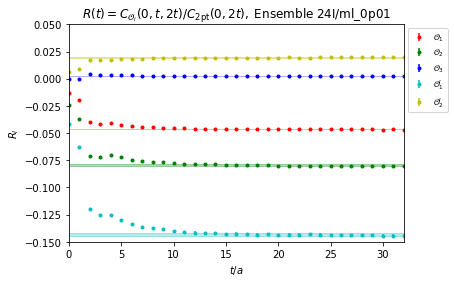

In [10]:
labels = ['$\mathcal{O}_1$', '$\mathcal{O}_2$', '$\mathcal{O}_3$', '$\mathcal{O}_1 \' $', '$\mathcal{O}_2\' $']
colors = ['r', 'g', 'b', 'c', 'y']
op_label = ['1', '2', '3', '1p', '2p']
plt.figure()
for i in range(n_ops):
    plt.errorbar(plot_domain, data_plot_μ[i], yerr = data_plot_σ[i], fmt = '.', c = colors[i], label = labels[i])
    #plt.fill_between(fit_regions[i], c[i] - σc[i], c[i] + σc[i], color = colors[i], alpha = 0.3)
    plt.fill_between(plot_domain, c[i] - σc[i], c[i] + σc[i], color = colors[i], alpha = 0.3)
plt.title('$R(t) = C_{\mathcal{O}_i}(0, t, 2t) / C_{2\mathrm{pt}}(0, 2t), \; \mathrm{Ensemble} \;$' + config)
# plt.title('$R(t) = C_{\mathcal{O}_i}(0, t, 2t) / C_{2\mathrm{pt}}(0, 2t), \; \mathrm{Ensemble} \; 24I/a m_{\ell} = 0.01.$')
plt.xlabel('$t / a$')
plt.ylabel('$R_i$')
plt.xlim((0, T // 2))
plt.ylim((-0.15, 0.05))
# plt.ylim((-0.042, -0.034))
# plt.ylim((-0.001, 0.025))
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 8})
plt.show()